# Bike sharing project - Tamas Becsei

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


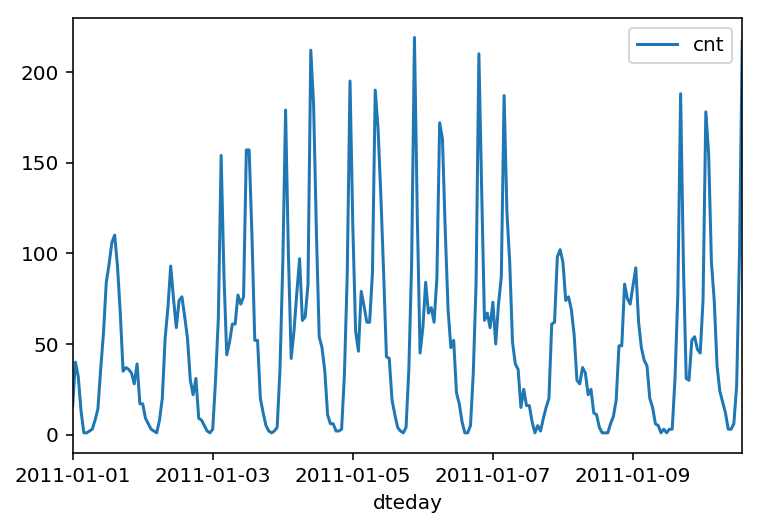

In [6]:
rides[:24*10].plot(x='dteday', y='cnt')

Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables.

In [7]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Scaling target variables

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

Splitting the data into training, testing, and validation sets

In [9]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating.

In [10]:
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

### Building the network


Two layers: hidden (sigmoid) + output (f(x)=x)

forward + backward propagation
  

In [11]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
    
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.input_nodes))
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.output_nodes, self.hidden_nodes))
        
        self.learning_rate = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # TODO: Activation function is the sigmoid function
        self.activation_function = lambda x: 1/(1+np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs
        
        # TODO: Backpropagated error
        hidden_error = np.dot(self.weights_hidden_to_output.T, output_errors) 
        hidden_grad = hidden_outputs * (1 - hidden_outputs)
        
        # TODO: Update the weights
        del_er_hidden = hidden_error * hidden_grad
        self.weights_hidden_to_output += self.learning_rate * output_errors * hidden_outputs.T
        self.weights_input_to_hidden += self.learning_rate * del_er_hidden * inputs.T
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

### Training the network

Stochastic Gradient Descent

Choosing the number of epochs

Choosing the learning rate

Choosing the number of hidden nodes


In [13]:
### Set the hyperparameters here ###
epochs = 10000
learning_rate = 0.01
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    if e%(epochs/10) == 0:
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        # Print out the losses as the network is training
        print('Training loss: {:.4f}'.format(train_loss))
        print('Validation loss: {:.4f}'.format(val_loss))
        

Training loss: 0.7446
Validation loss: 0.7586
Training loss: 0.1343
Validation loss: 0.1452
Training loss: 0.0750
Validation loss: 0.0797
Training loss: 0.0625
Validation loss: 0.0648
Training loss: 0.0615
Validation loss: 0.0663
Training loss: 0.0567
Validation loss: 0.0573
Training loss: 0.0533
Validation loss: 0.0571
Training loss: 0.0585
Validation loss: 0.0637
Training loss: 0.0569
Validation loss: 0.0618
Training loss: 0.0509
Validation loss: 0.0555


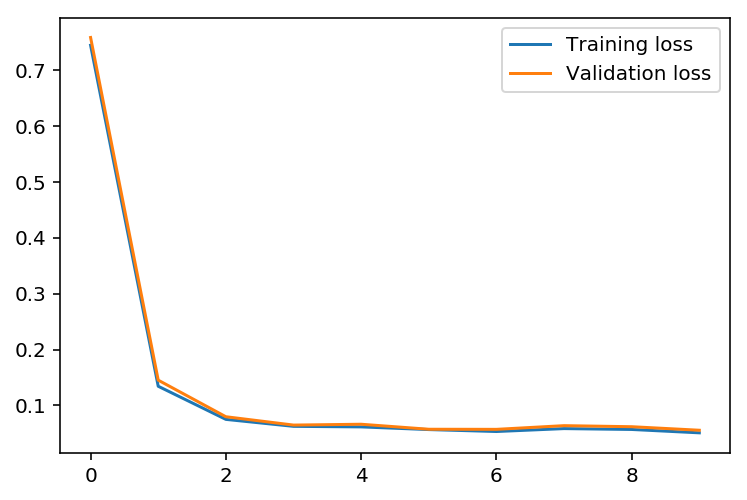

In [14]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

### Predictions

Using testing data to check the accuracy of predictions

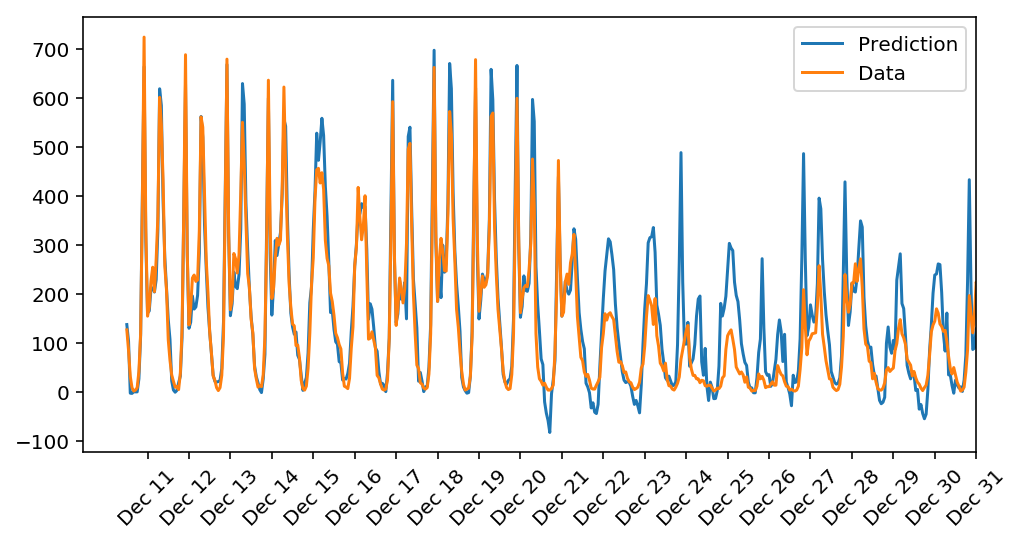

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## About my results
 
The accuracy of the predictions seems to be quite good. It looks like there is a decrease in accuracy for the second half of December, it might be caused by the holiday season.



## Unit tests

In [16]:
import unittest

np.random.seed(42)
inputs = [0.5, -0.2, 0.1]
targets = [0.4]

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path == 'Bike-Sharing-Dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    [ 0.22931895, -1.28754157]))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    [[-0.7128223, 0.22086344, -0.64139849],
                                     [-1.06444693, 1.06268915, -0.17280743]]))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.allclose(network.run(inputs), -0.97900982))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>